In [ ]:
! pip install SimpleITK
import SimpleITK as sitk
import numpy as np
import cv2
import matplotlib.pyplot as plt




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 16.5 MB/s eta 0:00:00


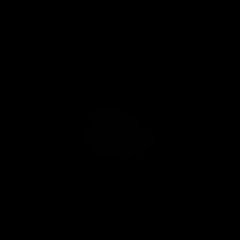

In [ ]:
from google.colab.patches import cv2_imshow
image = cv2.imread("tumor.png")
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
stencil = np.zeros(image.shape).astype(image.dtype)
contours, hierarchy = cv2.findContours(imgray,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contour = max(contours, key=cv2.contourArea)
image2=cv2.drawContours(image, [contour], -1, (0, 0, 255), -1)
imgray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
imgray2[imgray2==255]=0
imgray2[imgray2>0]=1
#image3=imgray[np.where(i)]
cv2_imshow(imgray2)


In [ ]:
arr=imgray2
img = sitk.GetImageFromArray(arr.astype(int))

# generate label 
filter_label = sitk.LabelShapeStatisticsImageFilter()
filter_label.SetComputeFeretDiameter(True)
filter_label.Execute(img)

# compute the Feret diameter
# the 1 means we are computing for the label with value 1
filter_label.GetFeretDiameter(1)

69.87131027825369

In [ ]:
# we have to get a bit smarter for the principal moments
pc1_x, pc1_y, pc2_x, pc2_y = filter_label.GetPrincipalAxes(1)
print(pc1_x, pc1_y, pc2_x, pc2_y)
# get the center of mass
com_y, com_x = filter_label.GetCentroid(1)

# now trace the distance from the centroid to the edge along the principal axes
# we use some linear algebra

# get the position of each point in the image
v_x, v_y = np.where(arr)

# convert these positions to a vector from the centroid
v_pts = np.array((v_x - com_x, v_y - com_y)).T

# project along the first principal component
distances_pc1 = np.dot(v_pts, np.array((pc1_x, pc1_y)))

# get the extent
dmax_1 = distances_pc1.max()
dmin_1 = distances_pc1.min()

# project along the second principal component
distances_pc2 = np.dot(v_pts, np.array((pc2_x, pc2_y)))

# get the extent
dmax_2 = distances_pc2.max()
dmin_2 = distances_pc2.min()

# the total diameter is the difference in these distances
print("Distance along major axis:", dmax_1 - dmin_1)
print("Distance along minor axis:", dmax_2 - dmin_2)

0.2717571059573108 -0.962365873959435 0.9623658739594352 0.27175710595731084
Distance along major axis: 67.21851662107295
Distance along minor axis: 57.380467306738026


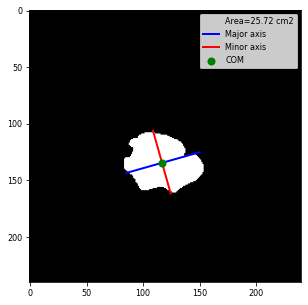

In [ ]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(arr, interpolation=None, cmap=plt.cm.Greys_r)
ax.plot([], [], ' ', label="Area=25.72 cm2")
ax.scatter(com_y, com_x, c="g", marker="o", s=50, zorder=99, label="COM")

ax.plot((com_y, com_y+dmax_1*pc1_y), (com_x, com_x+dmax_1*pc1_x), lw=2, c='b')
ax.plot((com_y, com_y+dmin_1*pc1_y), (com_x, com_x+dmin_1*pc1_x), lw=2, c='b', label="Major axis")

ax.plot((com_y, com_y+dmax_2*pc2_y), (com_x, com_x+dmax_2*pc2_x), lw=2, c='r')
ax.plot((com_y, com_y+dmin_2*pc2_y), (com_x, com_x+dmin_2*pc2_x), lw=2, c='r', label="Minor axis")



ax.legend()

fig.show()


major axis = [(84, 131), (153, 142), 69.87131027825369]
minor axis = [(99, 158), (107, 108), 50.635955604688654]


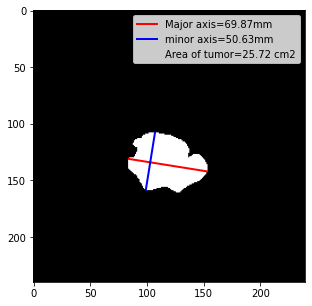

In [15]:
import cv2
import numpy as np
import math


from math import isclose 

import matplotlib
from matplotlib import pyplot as plt

Input_Path = "tumor.png"

Input_image = cv2.imread(Input_Path, cv2.IMREAD_GRAYSCALE)

RGB_image = cv2.cvtColor(Input_image, cv2.COLOR_GRAY2RGB)
Contour_image = RGB_image.copy()

Binary_Image = cv2.imread(Input_Path, cv2.IMREAD_GRAYSCALE)
ret,Binary_Image=cv2.threshold(Binary_Image,127,255,cv2.THRESH_BINARY)
area_in_cm2=str(np.count_nonzero(Binary_Image==255)/100)
Binary_Array = np.array(Binary_Image, dtype = 'uint8')


Contour, Hierarchy = cv2.findContours(Input_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contour_max = max(Contour, key=cv2.contourArea)



List = []
for p in contour_max:
        point_array = np.array(p[0], dtype = 'int')
        List.append(tuple(point_array))

Major_List = []
for p1 in range(0, len(List)):
    for p2 in range(p1+1, len(List)):

        Distance = math.sqrt(math.pow(List[p1][0] - List[p2][0], 2) + math.pow(List[p1][1] - List[p2][1], 2))
        Major_List.append([List[p1], List[p2], Distance])


Major_Axis = max(Major_List, key = lambda sublist: sublist[2])
print("major axis =",Major_Axis)


Minor_List = []
if (Major_Axis[1][1] - Major_Axis[0][1]) == 0:

    for p1 in range(0, len(List)):
      for p2 in range(p1+1, len(List)):

        if (List[p1][0] - List[p2][0]) == 0:

        
            Minor_Distance = math.sqrt(math.pow(List[p1][0] - List[p2][0], 2) + math.pow(List[p1][1] - List[p2][1], 2))
            Minor_List.append([List[p1], List[p2], Minor_Distance])

elif (Major_Axis[1][0] - Major_Axis[0][0]) == 0:

    for p1 in range(0, len(List)):
      for p2 in range(p1+1, len(List)):

        if (List[p1][1] - List[p2][1]) == 0:

          
            Minor_Distance = math.sqrt(math.pow(List[p1][0] - List[p2][0], 2) + math.pow(List[p1][1] - List[p2][1], 2))
            Minor_List.append([List[p1], List[p2], Minor_Distance])

else:
    Minor_Axis_Slope = (-1) * (Major_Axis[1][1] - Major_Axis[0][1]) / (Major_Axis[1][0] - Major_Axis[0][0])
    #Minor_Axis_Slope = (-1) * math.pow(Major_Axis_Slope, -1)

    for p1 in range(0, len(List)):
      for p2 in range(p1+1, len(List)):

        if (List[p1][0] - List[p2][0]) != 0 and (List[p1][1] - List[p2][1]) != 0 and isclose(((List[p1][0] - List[p2][0]) / (List[p1][1] - List[p2][1])), Minor_Axis_Slope, abs_tol = 1e-2):

       
            Minor_Distance = math.sqrt(math.pow(List[p1][0] - List[p2][0], 2) + math.pow(List[p1][1] - List[p2][1], 2))
            Minor_List.append([List[p1], List[p2], Minor_Distance])


Minor_Axis = max(Minor_List, key = lambda sublist: sublist[2])
print("minor axis =",Minor_Axis)

minor_axis_string=str(Minor_Axis[2])
major_axis_string=str(Major_Axis[2])

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(RGB_image, interpolation=None, cmap=plt.cm.Greys_r)
ax.plot((Major_Axis[0][0], Major_Axis[1][0]), (Major_Axis[0][1], Major_Axis[1][1]), lw=2, c='r', label="Major axis="+major_axis_string[:5]+"mm")
ax.plot((Minor_Axis[0][0], Minor_Axis[1][0]), (Minor_Axis[0][1], Minor_Axis[1][1]), lw=2, c='b', label="minor axis="+minor_axis_string[:5]+"mm")
ax.plot([], [], ' ', label="Area of tumor="+area_in_cm2+" cm2")
ax.legend()

fig.show()
